# Complaint Routing Model

#### by Jeffrey Strickland, Ph.D.
#### 12 August 2019

## Introduction

###### Goal: route complaints to the proper researched team based on product groupings. 

The business unit receives complaintsin the form of free text and wants to route the complaints to the wants to route the complaints to one of seven different depaertments (product_group name in the daata parenthesis:.
	1. Bank account or service (bank_servie)
	2. Credit card (credit_card)
	3. Credit reporting (credict_reporting)
	4. Debt collection (debt_collection)
	5. Lines of loans (loan)
	6. Mortgage (mortgange)

We have obtained a data set wiith 286,362 records that contains complaint text (text), a message identifier (complaint_id) and a verified correct complaint department product_group).

### Methodology

- We created three differnet classification models for comparison:

    - Naive Bayes
    - Classification Tree
    - Random Forest

- For of natural language processing (NLP) we chose the bag-of-words method.

## Load Required Packages

In [1]:
#Standard packages
import pandas as pd
import numpy as np
#import matplotlib
#from matplotlib import pyplot as plt

# Scikit Learn
from sklearn import preprocessing
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold

#Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatiser = WordNetLemmatizer()

#String
import string

import re
# Allow plots in Notebook
#%matplotlib inline

In [2]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

### Loading (reading) the Dataset using Pandas
Our first step in the modeling process is to load the data. In this instance the data is contained in a CVS file that we will read into the Jupyter Notebook.

In [3]:
df = pd.read_csv("D:/Documents/Data/case_study_data_copy.csv")

### Data Exploration
The next several step we take are for exploring the complaint data, including listing the headings, viewing some records, and assessing the shape of the data frame.

In [4]:
list(df)

['complaint_id', 'product_group', 'text']

In [5]:
df.shape

(263646, 3)

In [6]:
X = df['text']
y = df['product_group']

### Data Exploration

In [7]:
df.head(5) # for showing a snapshot of the dataset

,complaint_id,product_group,text
0,2815595,bank_service,On check was debited from checking account and...
1,2217937,bank_service,opened a Bank of the the West account The acco...
2,2657456,bank_service,in nj opened a business account without author...
3,1414106,bank_service,A hold was placed on saving account because in...
4,1999158,bank_service,Dear CFPBneed to send a major concerncomplaint...


## Prepare a Frequency Distribution

The next step consist of plotting the frequency of complaints for each product group and plotting the word counts

In [8]:
# Provides calculation of the shape of the data for each product group
bank_service_len = df[df['product_group'] == 'bank_service'].shape[0]
mortgage_len = df[df['product_group'] == 'mortgage'].shape[0]
credit_reporting_len = df[df['product_group'] == 'credit_reporting'].shape[0]
loan_len = df[df['product_group'] == 'loan'].shape[0]
credit_card_len = df[df['product_group'] == 'credit_card'].shape[0]
debt_collection_len = df[df['product_group'] == 'debt_collection'].shape[0]

In [9]:
# Returns that complaint frequencies for each product group
credit_reporting_len, mortgage_len, bank_service_len, loan_len, credit_card_len

(81234, 40281, 20071, 31036, 29553)

In [13]:
df_freq = df.groupby('product_group').text.count()
df_freq


product_group
bank_service        20071
credit_card         29553
credit_reporting    81232
debt_collection     61471
loan                31036
mortgage            40281
Name: text, dtype: int64

## Plotting the Data

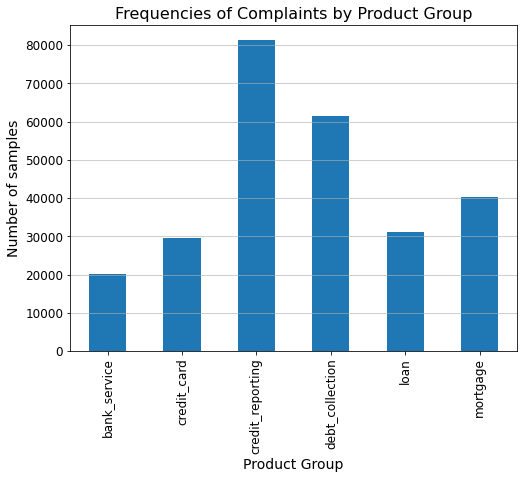

In [12]:
plt.figure(figsize = [8,6])
df.groupby('product_group').text.count().plot.bar(ylim = 0)
plt.grid(axis = 'y', alpha = 0.75)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Number of samples', fontsize = 14)
plt.xlabel('Product Group', fontsize = 14)
plt.title('Frequencies of Complaints by Product Group', fontsize = 16)
plt.show()

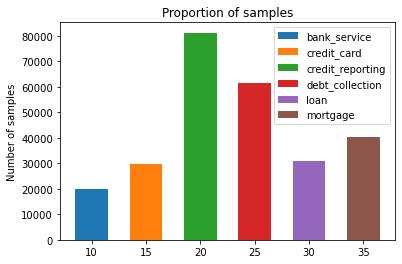

In [15]:
# Sets up the data for construct the frequency distribution (bar chart)
plt.bar(10,bank_service_len,3, label="bank_service")
plt.bar(15,credit_card_len,3, label="credit_card")
plt.bar(20,credit_reporting_len,3, label="credit_reporting")
plt.bar(25,debt_collection_len,3, label="debt_collection")
plt.bar(30,loan_len,3, label="loan")
plt.bar(35,mortgage_len,3, label="mortgage")
plt.legend()
plt.ylabel('Number of samples')
plt.title('Proportion of samples')
plt.show()

## Label Encoding of Classes:

- As this is a classification problem, here classes are the 7 product groups as mentioned. In our dataset, the labels are non-numeric (bank_services, credit_card, credit_reporting, debt_collection, loan, money_transfers, and mortgage). 
- These are label encoded to make them numeric, starting from 0 depicting each label in the alphabetic order i.e., (0 → bank_services, 1 → credit_card, 2 → credit_reporting, 3 → debt_collection, 4 → loan, 5 → money_transfers, and 5 → mortgage).

In [18]:
# Importing necessary libraries
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
yL = labelencoder.fit_transform(y)
yL

array([0, 0, 0, ..., 5, 5, 5])

Text(0, 0.5, 'Frequencies')

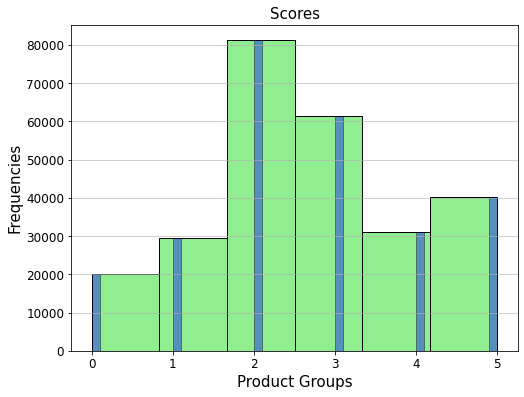

In [20]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.figure(figsize = [8,6])
plt.hist(yL, color = 'lightgreen', edgecolor = 'black',bins = 6)
# seaborn histogram
sns.distplot(yL, hist = True, kde = False, 
             bins = None, color = 'blue',
             hist_kws = {'edgecolor':'black'})
# Add labels
plt.grid(axis = 'y', alpha = 0.75)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Scores',fontsize = 15)
plt.xlabel('Product Groups',fontsize = 15)
plt.ylabel('Frequencies',fontsize = 15)

In [21]:
from io import StringIO
col = ['product_group', 'text']
df = df[col]
df = df[pd.notnull(df['text'])]
df.columns = ['product_group', 'text']
df['category_id'] = df['product_group'].factorize()[0]
category_id_df = df[['product_group', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'product_group']].values)
df.head()

,product_group,text,category_id
0,bank_service,On check was debited from checking account and...,0
1,bank_service,opened a Bank of the the West account The acco...,0
2,bank_service,in nj opened a business account without author...,0
3,bank_service,A hold was placed on saving account because in...,0
4,bank_service,Dear CFPBneed to send a major concerncomplaint...,0


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
features = tfidf.fit_transform(df.text)
labels = df.category_id
features.shape

(263644, 115788)

In [23]:
#DO NOT CHANGE#
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf= TfidfVectorizer(sublinear_tf=True, 
                       min_df=5, 
                       norm='l2', 
                       encoding='latin-1', 
                       ngram_range=(1, 3), 
                       stop_words='english',
                       lowercase=True,       
                       token_pattern=r'\b\w+\b',       
                       analyzer='word', 
                      )
features = tfidf.fit_transform(df.text)
labels = df.category_id

((263644, 872010), (210915, 872010), (52729, 872010))

In [25]:
from sklearn.feature_selection import chi2
import numpy as np
N = 3
for product_group, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print("# '{}':".format(product_group))
    print(" . Most correlated unigrams:\n     . {}".format('\n     . '.join(unigrams[-N:])))
    print(" . Most correlated bigrams:\n     . {}".format('\n     . '.join(bigrams[-N:])))
    print(" . Most correlated trigrams:\n     . {}".format('\n     . '.join(trigrams[-N:])))

# 'bank_service':
 . Most correlated unigrams:
     . bank
     . deposit
     . overdraft
 . Most correlated bigrams:
     . debit card
     . overdraft fees
     . checking account
 . Most correlated trigrams:
     . checking account bank
     . citigold checking account
     . opened checking account
# 'credit_card':
 . Most correlated unigrams:
     . rewards
     . express
     . card
 . Most correlated bigrams:
     . annual fee
     . american express
     . credit card
 . Most correlated trigrams:
     . bank credit card
     . credit card account
     . credit card company
# 'credit_reporting':
 . Most correlated unigrams:
     . report
     . experian
     . equifax
 . Most correlated bigrams:
     . credit reporting
     . credit file
     . credit report
 . Most correlated trigrams:
     . inquiries credit report
     . mistakes appear report
     . appear report understanding
# 'debt_collection':
 . Most correlated unigrams:
     . collect
     . collection
     . debt
 . 

## Create Train and Test Sets

In [24]:
from sklearn.model_selection import train_test_split

# 70-30 splitting the dataset (80%->Training and 20%->Validation)
X_train, X_test, y_train, y_test = train_test_split(features, labels
                                  ,test_size=0.3, random_state=1234)
features.shape, X_train.shape, X_test.shape

((263644, 872010), (184550, 872010), (79094, 872010))

## Feature Engineering using Bag-of-Words:

- Machine Learning Algorithms work only on numeric data. 
- But here, data is present in the form of text only. 
- For that, by some means, textual data needs to be transformed into numeric form. 
- One such approach of doing this, is Feature Engineering. 
- In this approach, numeric features are extracted or engineered from textual data. 
- There are many Feature Engineering Techniques in existence. 
- In this problem, Bag-of-Words Technique of Feature Engineering has been used.

### Bag-of-Words (BOW):

- With Bag-of-Words a vocabulary of words present in the corpus is maintained. 
- These words serve as features for each instance or document (each complaint). 
- Against each word as feature, its frequency in the current document (complaint) is considered. 
- In this way word features are engineered or extracted from the textual data or corpus.

### BOW Preparation

In [16]:
# defining the bag-of-words transformer on the text-processed corpus 
# i.e., text_process() declared in II is executed...
#bow_transformer=CountVectorizer(analyzer=text_process).fit(X_train)
bow_transformer=CountVectorizer().fit(X_train)

In [17]:
# transforming into Bag-of-Words and hence textual data to numeric..
text_bow_train=bow_transformer.transform(X_train)#ONLY TRAINING DATA

In [18]:
# transforming into Bag-of-Words and hence textual data to numeric..
text_bow_test=bow_transformer.transform(X_test)#TEST DATA

In [26]:
# Importing necessary libraries
from sklearn.naive_bayes import MultinomialNB

# instantiating the model with Multinomial Naive Bayes..
model = MultinomialNB()

# training the model...
model = model.fit(X_train, y_train)

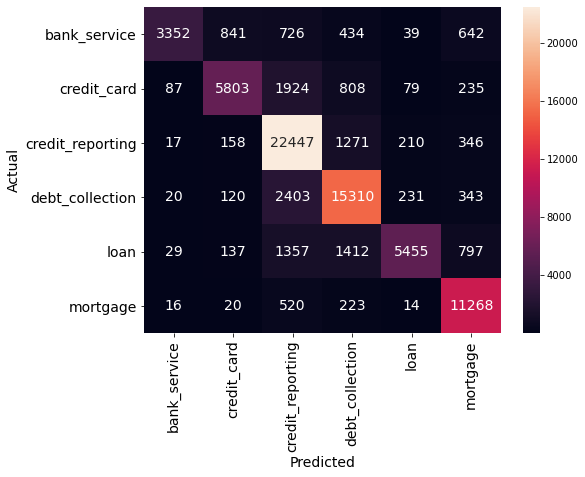

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 14}, fmt='d',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()

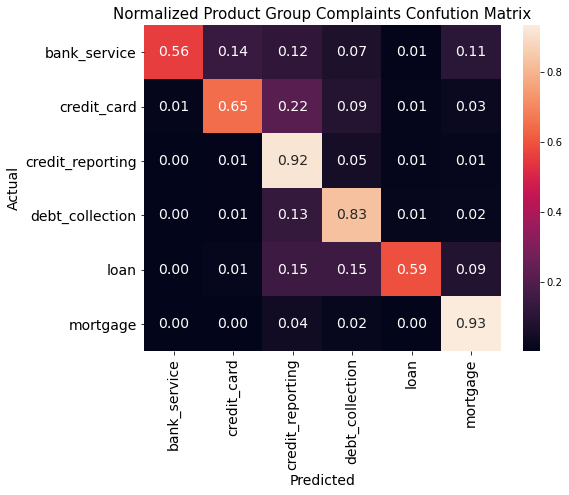

In [30]:
conf_sum = np.sum(conf_mat, axis=1, keepdims=True)
cm_perc = conf_mat / (conf_sum.astype(float))
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm_perc, annot=True, annot_kws={"size": 14}, fmt='.2f',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.title('Normalized Product Group Complaints Confution Matrix', fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()
%matplotlib inline

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.56      0.70      6034
           1       0.82      0.65      0.72      8936
           2       0.76      0.92      0.83     24449
           3       0.79      0.83      0.81     18427
           4       0.90      0.59      0.72      9187
           5       0.83      0.93      0.88     12061

    accuracy                           0.80     79094
   macro avg       0.84      0.75      0.78     79094
weighted avg       0.82      0.80      0.80     79094



In [81]:
# Importing necessary libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# 80-20 splitting the dataset (80%->Training and 20%->Validation)
X_train, X_test, y_train, y_test = train_test_split(X, y
                                  ,test_size=0.2, random_state=1234)

## Training the Multinomial Naive Bayes Model:

Multinomial Naive Bayes Algorithm (Classifier) has been used as the Classification Machine Learning Algorithm [1].

In [19]:
# Importing necessary libraries
from sklearn.naive_bayes import MultinomialNB

# instantiating the model with Multinomial Naive Bayes..
model = MultinomialNB()

# training the model...
model = model.fit(text_bow_train, y_train)

### Model Performance Analysis:

#### Training Accuracy

In [20]:
bayes_score = model.score(text_bow_train, y_train)
bayes_score

0.8305939248348453

#### Validation Accuracy

In [21]:
bayes_val_score = model.score(text_bow_test, y_test)
bayes_val_score

0.8146532650610026

The cross-validation score is very close to the model score, 80.99 versus 82.44. The naive Bayes model is a good fit of the data and will produce good predictions.


### Precision, Recall and F1–Score

In [22]:
# Importing necessary libraries
from sklearn.metrics import classification_report
 
# getting the predictions of the Validation Set...
bayes_preds = model.predict(text_bow_test)

# getting the Precision, Recall, F1-Score
print(classification_report(y_test,bayes_preds))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      1237
           1       0.72      0.78      0.75      1714
           2       0.82      0.84      0.83      4752
           3       0.85      0.76      0.80      3731
           4       0.74      0.78      0.76      1907
           5       0.90      0.90      0.90      2478

    accuracy                           0.81     15819
   macro avg       0.81      0.81      0.81     15819
weighted avg       0.82      0.81      0.81     15819



### Naive Bayes Predictions

In [ ]:
bayes_preds[0:10]

In [ ]:
model.predict_proba(text_bow_test)

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB
#from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
features = X_train
labels = y_train
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    SGDClassifier(),
    RidgeClassifier(tol=1e-2, solver="sag"),
    Perceptron(max_iter=25),
    LogisticRegression(random_state=0),
]

C:\Users\jeff\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jeff\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


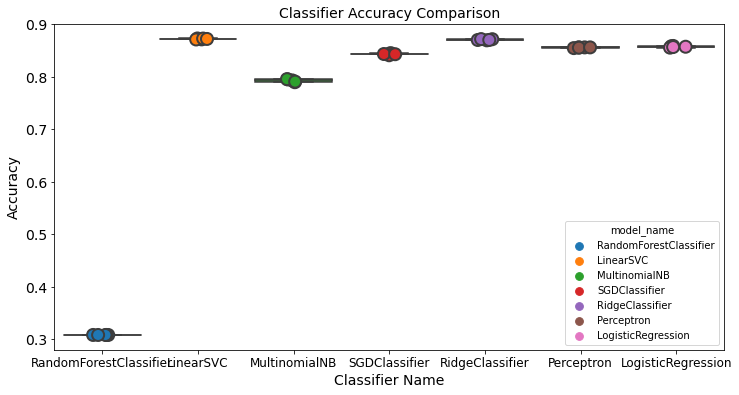

In [36]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
plt.figure(figsize=[12,6])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, hue='model_name',
              size=12, jitter=True, edgecolor="gray", linewidth=2)
plt.title('Classifier Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Classifier Name', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.show()

In [37]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.872138
LogisticRegression        0.857339
MultinomialNB             0.792820
Perceptron                0.855708
RandomForestClassifier    0.307700
RidgeClassifier           0.870707
SGDClassifier             0.843365
Name: accuracy, dtype: float64

# Confusion Matrices

In [221]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Linear SVM Classifier

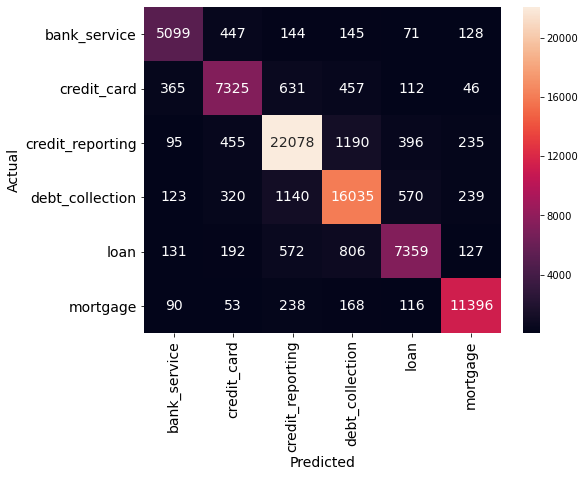

In [52]:
svm_class = LinearSVC()
svm_class.fit(X_train, y_train)
svm_pred = svm_class.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 14}, fmt='d',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()

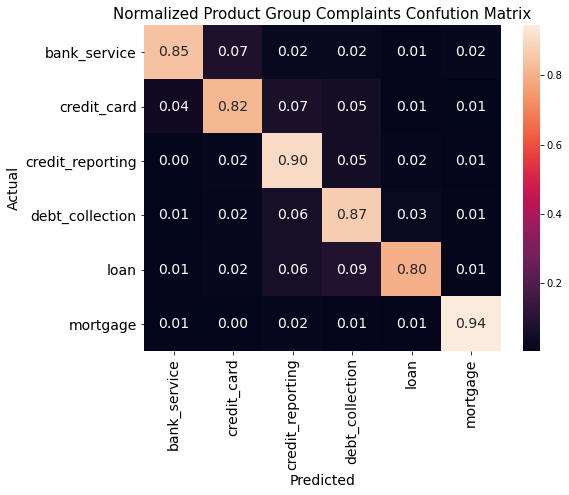

In [53]:
conf_sum = np.sum(conf_mat, axis=1, keepdims=True)
cm_perc = conf_mat / (conf_sum.astype(float))
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm_perc, annot=True, annot_kws={"size": 14}, fmt='.2f',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.title('Normalized Product Group Complaints Confution Matrix', fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()
%matplotlib inline

In [54]:
svm_score = svm_class.score(X_train, y_train)
svm_val_score = svm_class.score(X_test, y_test)
svm_score, svm_val_score

(0.9942942292061772, 0.8760715098490404)

In [55]:
from sklearn.metrics import f1_score, precision_score, recall_score
print("Accuracy: %.3f%%" % (svm_score*100.0))
print("F1 Score: ", f1_score(y_test, svm_pred, average="macro"))
print("Precision Score: ", precision_score(y_test, svm_pred, average="macro"))
print("Recall Score: ", recall_score(y_test, svm_pred, average="macro")) 

Accuracy: 99.429%
F1 Score:  0.8675946873144587
Precision Score:  0.8715908500556143
Recall Score:  0.8639771059756717


In [56]:
from sklearn.metrics import classification_report
print(classification_report(y_test,svm_pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      6034
           1       0.83      0.82      0.83      8936
           2       0.89      0.90      0.90     24449
           3       0.85      0.87      0.86     18427
           4       0.85      0.80      0.83      9187
           5       0.94      0.94      0.94     12061

    accuracy                           0.88     79094
   macro avg       0.87      0.86      0.87     79094
weighted avg       0.88      0.88      0.88     79094



## Multinomial Naibe Bayes Classifier

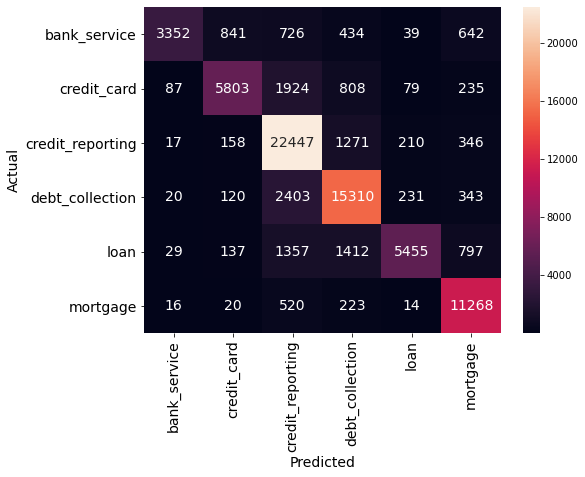

In [57]:
mnb_class = MultinomialNB()
mnb_class.fit(X_train, y_train)
mnb_pred = mnb_class.predict(X_test)
conf_mat = confusion_matrix(y_test, mnb_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 14}, fmt='d',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()

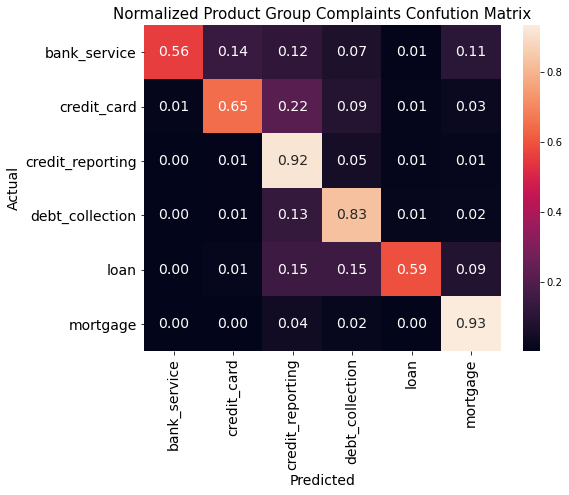

In [58]:
conf_sum = np.sum(conf_mat, axis=1, keepdims=True)
cm_perc = conf_mat / (conf_sum.astype(float))
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm_perc, annot=True, annot_kws={"size": 14}, fmt='.2f',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.title('Normalized Product Group Complaints Confution Matrix', fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()
%matplotlib inline

In [59]:
mnb_score = mnb_class.score(X_train, y_train)
mnb_val_score = mnb_class.score(X_test, y_test)
mnb_score, mnb_val_score

(0.846393931183961, 0.8045490176245986)

In [60]:
print("Accuracy: %.3f%%" % (mnb_score*100.0))
print("F1 Score: ", f1_score(y_test, mnb_pred, average="macro"))
print("Precision Score: ", precision_score(y_test, mnb_pred, average="macro"))
print("Recall Score: ", recall_score(y_test, mnb_pred, average="macro")) 

Accuracy: 84.639%
F1 Score:  0.7771378112748074
Precision Score:  0.8423772726607183
Recall Score:  0.7469834055971787


In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_test,mnb_pred))

              precision    recall  f1-score   support

           0       0.95      0.56      0.70      6034
           1       0.82      0.65      0.72      8936
           2       0.76      0.92      0.83     24449
           3       0.79      0.83      0.81     18427
           4       0.90      0.59      0.72      9187
           5       0.83      0.93      0.88     12061

    accuracy                           0.80     79094
   macro avg       0.84      0.75      0.78     79094
weighted avg       0.82      0.80      0.80     79094



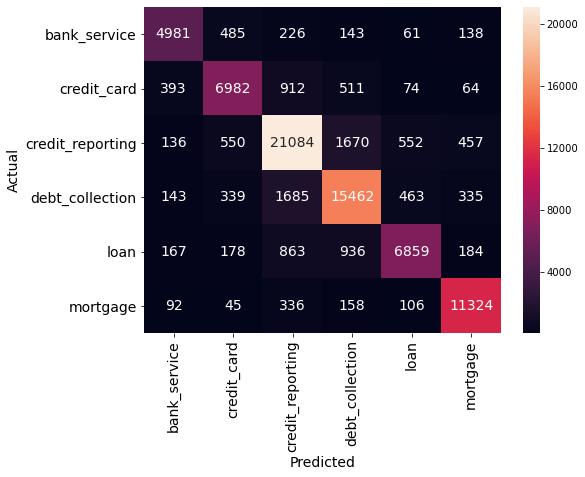

In [64]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sgd_class = SGDClassifier()
sgd_class.fit(X_train, y_train)
sgd_pred = sgd_class.predict(X_test)
conf_mat = confusion_matrix(y_test, sgd_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 14}, fmt='d',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()

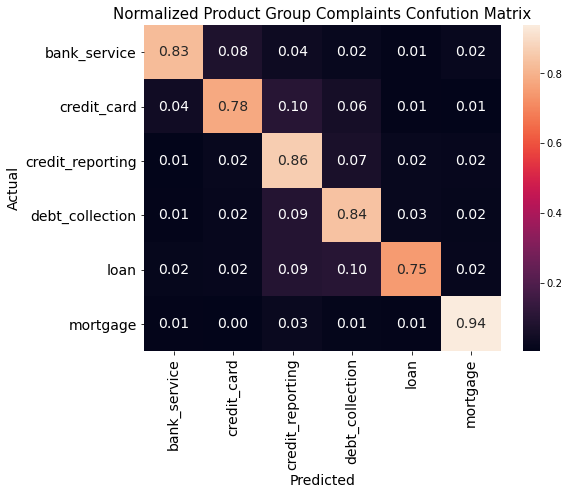

In [65]:
conf_sum = np.sum(conf_mat, axis=1, keepdims=True)
cm_perc = conf_mat / (conf_sum.astype(float))
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm_perc, annot=True, annot_kws={"size": 14}, fmt='.2f',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.title('Normalized Product Group Complaints Confution Matrix', fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()
%matplotlib inline

In [66]:
sgd_score = sgd_class.score(X_train, y_train)
sgd_val_score = sgd_class.score(X_test, y_test)
sgd_score, sgd_val_score

(0.8586128420482254, 0.8431992312944092)

In [67]:
print("model: ", "SGDClassifier")
print("Accuracy: %.3f%%" % (sgd_score*100.0))
print("F1 Score: ", f1_score(y_test, sgd_pred, average="macro"))
print("Precision Score: ", precision_score(y_test, sgd_pred, average="macro"))
print("Recall Score: ", recall_score(y_test, sgd_pred, average="macro")) 

model:  SGDClassifier
Accuracy: 85.861%
F1 Score:  0.8376519554772233
Precision Score:  0.8443554220332095
Recall Score:  0.8322961003301215


In [68]:
from sklearn.metrics import classification_report
print(classification_report(y_test,sgd_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      6034
           1       0.81      0.78      0.80      8936
           2       0.84      0.86      0.85     24449
           3       0.82      0.84      0.83     18427
           4       0.85      0.75      0.79      9187
           5       0.91      0.94      0.92     12061

    accuracy                           0.84     79094
   macro avg       0.84      0.83      0.84     79094
weighted avg       0.84      0.84      0.84     79094



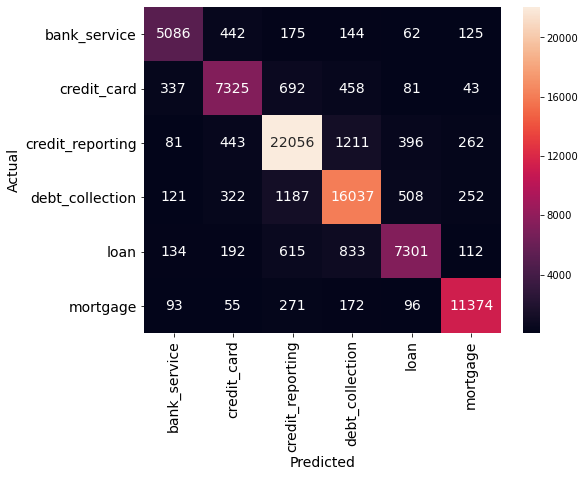

In [69]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
rdg_class = RidgeClassifier(tol=1e-2, solver="sag")
rdg_class.fit(X_train, y_train)
rdg_pred = rdg_class.predict(X_test)
conf_mat = confusion_matrix(y_test, rdg_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 14}, fmt='d',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()

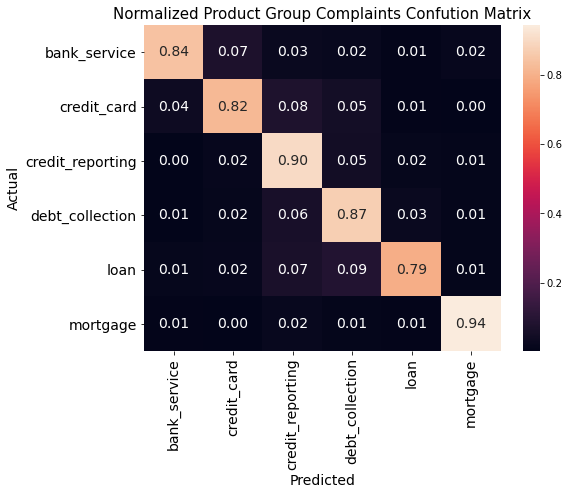

In [70]:
conf_sum = np.sum(conf_mat, axis=1, keepdims=True)
cm_perc = conf_mat / (conf_sum.astype(float))
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm_perc, annot=True, annot_kws={"size": 14}, fmt='.2f',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.title('Normalized Product Group Complaints Confution Matrix', fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()
%matplotlib inline

In [71]:
rdg_score = rdg_class.score(X_train, y_train)
rdg_val_score = rdg_class.score(X_test, y_test)
rdg_score, rdg_val_score

(0.9806393931183961, 0.8746428300503198)

In [72]:
print("model: ", "RidgeClassifier")
print("Accuracy: %.3f%%" % (rdg_score*100.0))
print("F1 Score: ", f1_score(y_test, rdg_pred, average="macro"))
print("Precision Score: ", precision_score(y_test, rdg_pred, average="macro"))
print("Recall Score: ", recall_score(y_test, rdg_pred, average="macro")) 

model:  RidgeClassifier
Accuracy: 98.064%
F1 Score:  0.8670509096429808
Precision Score:  0.8726318940505552
Recall Score:  0.8621299253489152


In [73]:
from sklearn.metrics import classification_report
print(classification_report(y_test,rdg_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      6034
           1       0.83      0.82      0.83      8936
           2       0.88      0.90      0.89     24449
           3       0.85      0.87      0.86     18427
           4       0.86      0.79      0.83      9187
           5       0.93      0.94      0.94     12061

    accuracy                           0.87     79094
   macro avg       0.87      0.86      0.87     79094
weighted avg       0.87      0.87      0.87     79094



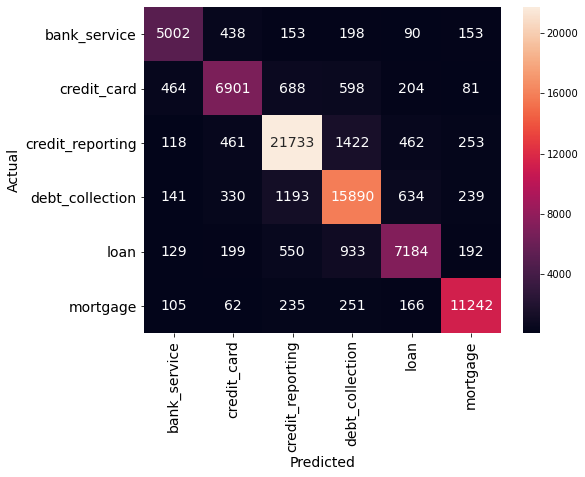

In [74]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
pct_class = Perceptron(max_iter=25)
pct_class.fit(X_train, y_train)
pct_pred = pct_class.predict(X_test)
conf_mat = confusion_matrix(y_test, pct_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 14}, fmt='d',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()

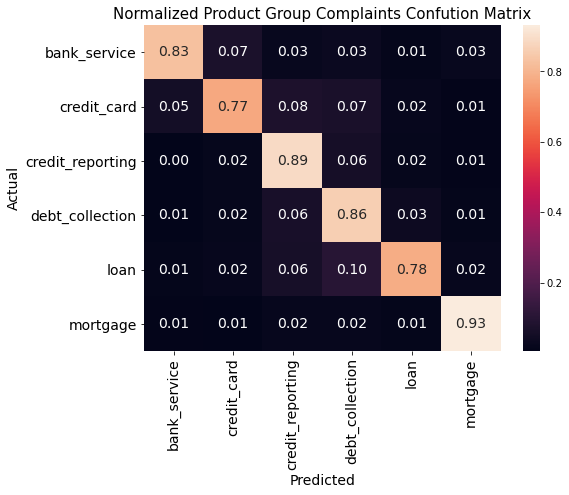

In [75]:
conf_sum = np.sum(conf_mat, axis=1, keepdims=True)
cm_perc = conf_mat / (conf_sum.astype(float))
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm_perc, annot=True, annot_kws={"size": 14}, fmt='.2f',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.title('Normalized Product Group Complaints Confution Matrix', fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()
%matplotlib inline

In [76]:
pct_score = pct_class.score(X_train, y_train)
pct_val_score = pct_class.score(X_test, y_test)
pct_score, pct_val_score

(0.997821728528854, 0.8591296432093458)

In [77]:
print("model: ", "Perceptron")
print("Accuracy: %.3f%%" % (pct_score*100.0))
print("F1 Score: ", f1_score(y_test, pct_pred, average="macro"))
print("Precision Score: ", precision_score(y_test, pct_pred, average="macro"))
print("Recall Score: ", recall_score(y_test, pct_pred, average="macro")) 

model:  Perceptron
Accuracy: 99.782%
F1 Score:  0.8483434778978386
Precision Score:  0.8528576439792045
Recall Score:  0.8444235939606773


In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pct_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      6034
           1       0.82      0.77      0.80      8936
           2       0.89      0.89      0.89     24449
           3       0.82      0.86      0.84     18427
           4       0.82      0.78      0.80      9187
           5       0.92      0.93      0.93     12061

    accuracy                           0.86     79094
   macro avg       0.85      0.84      0.85     79094
weighted avg       0.86      0.86      0.86     79094



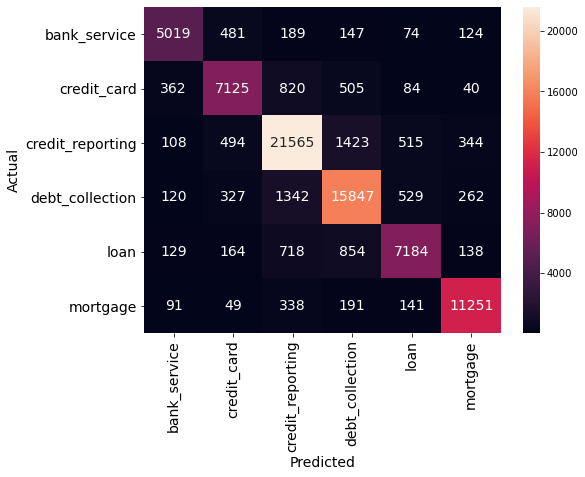

In [80]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
log_class = LogisticRegression(random_state=0)
log_class.fit(X_train, y_train)
log_pred = log_class.predict(X_test)
conf_mat = confusion_matrix(y_test, log_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 14}, fmt='d',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()

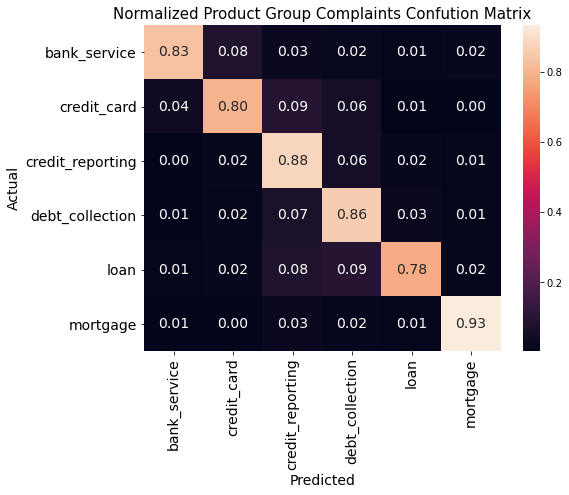

In [81]:
conf_sum = np.sum(conf_mat, axis=1, keepdims=True)
cm_perc = conf_mat / (conf_sum.astype(float))
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm_perc, annot=True, annot_kws={"size": 14}, fmt='.2f',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.title('Normalized Product Group Complaints Confution Matrix', fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()
%matplotlib inline

In [82]:
log_score = log_class.score(X_train, y_train)
log_val_score = log_class.score(X_test, y_test)
log_score, log_val_score

(0.9018531563261989, 0.8596227273876653)

In [84]:
print("model: ", "LogisticRegression")
print("Accuracy: %.3f%%" % (log_score*100.0))
print("F1 Score: ", f1_score(y_test, log_pred, average="macro"))
print("Precision Score: ", precision_score(y_test, log_pred, average="macro"))
print("Recall Score: ", recall_score(y_test, log_pred, average="macro")) 

model:  LogisticRegression
Accuracy: 90.185%
F1 Score:  0.8528961360815561
Precision Score:  0.8587644119198213
Recall Score:  0.8476612173212149


In [85]:
from sklearn.metrics import classification_report
print(classification_report(y_test,log_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      6034
           1       0.82      0.80      0.81      8936
           2       0.86      0.88      0.87     24449
           3       0.84      0.86      0.85     18427
           4       0.84      0.78      0.81      9187
           5       0.93      0.93      0.93     12061

    accuracy                           0.86     79094
   macro avg       0.86      0.85      0.85     79094
weighted avg       0.86      0.86      0.86     79094



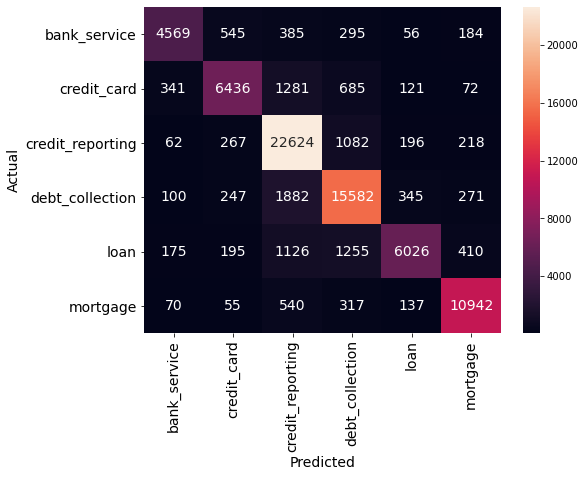

In [90]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
rf_class = RandomForestClassifier(n_estimators=100)
rf_class.fit(X_train, y_train)
rf_pred = rf_class.predict(X_test)
conf_mat = confusion_matrix(y_test, rf_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 14}, fmt='d',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()

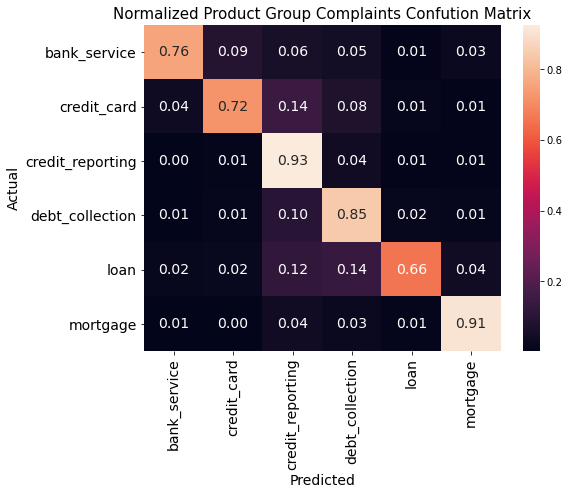

In [91]:
conf_sum = np.sum(conf_mat, axis=1, keepdims=True)
cm_perc = conf_mat / (conf_sum.astype(float))
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm_perc, annot=True, annot_kws={"size": 14}, fmt='.2f',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.title('Normalized Product Group Complaints Confution Matrix', fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()
%matplotlib inline

In [92]:
rf_score = rf_class.score(X_train, y_train)
rf_val_score = rf_class.score(X_test, y_test)
rf_score, rf_val_score

(0.9989867244649147, 0.8367132778718993)

In [93]:
print("model: ", "Random Forest")
print("Accuracy: %.3f%%" % (log_score*100.0))
print("F1 Score: ", f1_score(y_test, log_pred, average="macro"))
print("Precision Score: ", precision_score(y_test, log_pred, average="macro"))
print("Recall Score: ", recall_score(y_test, log_pred, average="macro")) 

model:  Random Forest
Accuracy: 90.185%
F1 Score:  0.8528961360815561
Precision Score:  0.8587644119198213
Recall Score:  0.8476612173212149


In [94]:
from sklearn.metrics import classification_report
print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.86      0.76      0.81      6034
           1       0.83      0.72      0.77      8936
           2       0.81      0.93      0.87     24449
           3       0.81      0.85      0.83     18427
           4       0.88      0.66      0.75      9187
           5       0.90      0.91      0.91     12061

    accuracy                           0.84     79094
   macro avg       0.85      0.80      0.82     79094
weighted avg       0.84      0.84      0.83     79094



# Training the Classification Tree Model

In [174]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(text_bow_train, y_train)

In [175]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Classification Tree Scores

In [176]:
tree_score = clf.score(text_bow_train, y_train)
tree_score

0.9995258716060309

In [177]:
tree_val_score = clf.score(text_bow_test, y_test)
tree_val_score

0.7310828750237057

The cross-validation score is much lower than the model score, 75.83 versus 99.91. The classificaton tree model is over-fitting the data and will produce numerous false positives.


### Classification Tree Predictions

In [178]:
tree_preds = clf.predict(text_bow_test)
tree_preds[0:10]

array(['debt_collection', 'mortgage', 'debt_collection',
       'credit_reporting', 'debt_collection', 'credit_reporting',
       'bank_service', 'mortgage', 'credit_reporting', 'credit_reporting'],
      dtype=object)

In [179]:
clf.predict_proba(text_bow_test)

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

### Tree Summary

According to the Performance Analysis, we can conclude that this model may be overfitting the data, given th significant difference wetween train and test scores. 
- Train: 99.91% 
- Test: 75.94%

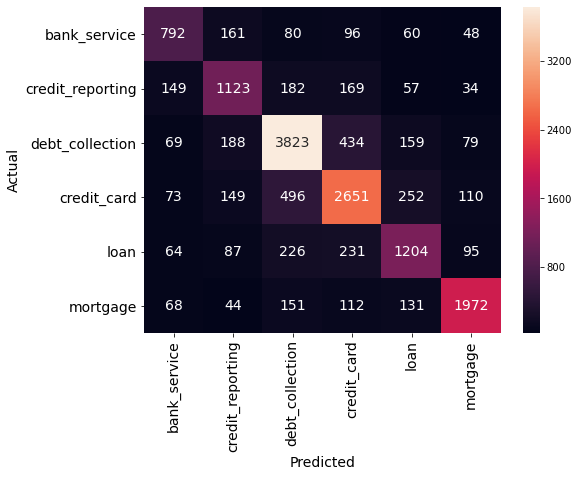

In [180]:
#model = MultinomialNB()
#model.fit(text_bow_train, y_train)
y_pred = clf.predict(text_bow_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 14}, fmt='d',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()

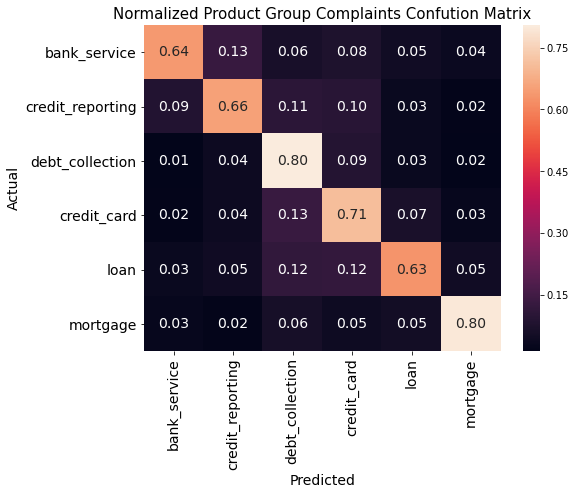

In [181]:
conf_sum = np.sum(conf_mat, axis=1, keepdims=True)
cm_perc = conf_mat / (conf_sum.astype(float))
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm_perc, annot=True, annot_kws={"size": 14}, fmt='.2f',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.title('Normalized Product Group Complaints Confution Matrix', fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()
%matplotlib inline

In [182]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

                  precision    recall  f1-score   support

    bank_service       0.65      0.64      0.65      1237
     credit_card       0.64      0.66      0.65      1714
credit_reporting       0.77      0.80      0.79      4752
 debt_collection       0.72      0.71      0.71      3731
            loan       0.65      0.63      0.64      1907
        mortgage       0.84      0.80      0.82      2478

        accuracy                           0.73     15819
       macro avg       0.71      0.71      0.71     15819
    weighted avg       0.73      0.73      0.73     15819



# Training the Random Forest Model

In [197]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
#from sklearn.cross_validation import cross_val_score

In [198]:
rf_class = RandomForestClassifier(n_estimators=100) # initialize
rf_class.fit(X_train, y_train) # fit the data to the algorithm

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Random Forest Model Scores

In [199]:
rf_score = rf_class.score(X_train, y_train)
rf_score

0.9995258716060309

In [200]:
rf_val_score = rf.score(X_test, y_test)
rf_val_score

0.7982805487072507

In [201]:
rf.get_params(rf.fit)

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Random Forest Predictions

In [202]:
forest_preds = rf.predict(text_bow_test)
forest_preds[0:10]

array(['credit_card', 'bank_service', 'debt_collection', 'credit_card',
       'credit_reporting', 'credit_reporting', 'bank_service', 'mortgage',
       'credit_reporting', 'credit_reporting'], dtype=object)

In [203]:
rf.predict_proba(text_bow_test)[0:10]

array([[0.05, 0.37, 0.16, 0.18, 0.08, 0.16],
       [0.22, 0.19, 0.05, 0.22, 0.16, 0.16],
       [0.01, 0.04, 0.31, 0.54, 0.07, 0.03],
       [0.14, 0.24, 0.16, 0.17, 0.11, 0.18],
       [0.04, 0.07, 0.44, 0.24, 0.14, 0.07],
       [0.01, 0.  , 0.58, 0.35, 0.03, 0.03],
       [0.31, 0.1 , 0.25, 0.14, 0.1 , 0.1 ],
       [0.06, 0.09, 0.07, 0.04, 0.08, 0.66],
       [0.05, 0.04, 0.76, 0.13, 0.02, 0.  ],
       [0.14, 0.18, 0.33, 0.17, 0.12, 0.06]])

### Random Forest Summary

The random forest model is probably over-fitting the data and will produce numerous false positives. The cross-validation score is much lower than the model score. 
- Train: 99.91. 
- Test: 82.45  

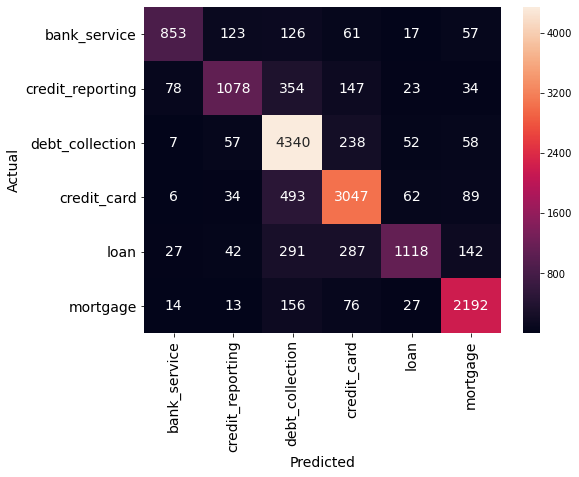

In [204]:
y_pred = rf.predict(text_bow_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 14}, fmt='d',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()

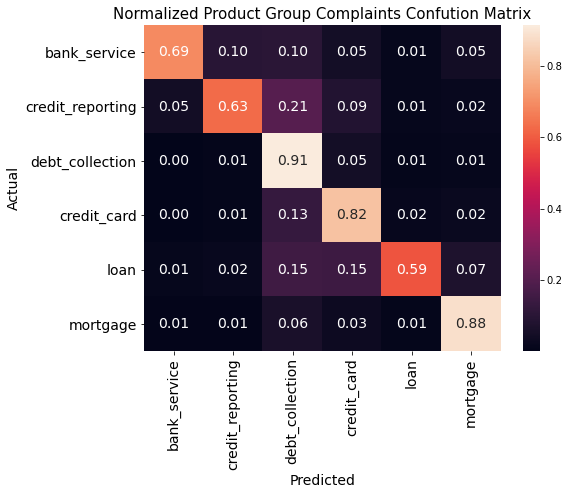

In [205]:
conf_sum = np.sum(conf_mat, axis=1, keepdims=True)
cm_perc = conf_mat / (conf_sum.astype(float))
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm_perc, annot=True, annot_kws={"size": 14}, fmt='.2f',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.title('Normalized Product Group Complaints Confution Matrix', fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()
%matplotlib inline

In [206]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

                  precision    recall  f1-score   support

    bank_service       0.87      0.69      0.77      1237
     credit_card       0.80      0.63      0.70      1714
credit_reporting       0.75      0.91      0.83      4752
 debt_collection       0.79      0.82      0.80      3731
            loan       0.86      0.59      0.70      1907
        mortgage       0.85      0.88      0.87      2478

        accuracy                           0.80     15819
       macro avg       0.82      0.75      0.78     15819
    weighted avg       0.80      0.80      0.79     15819



# Model Comparisons

In [207]:
bayes_preds[0:20], tree_preds[0:20], forest_preds[0:20]

(array([1, 0, 3, 1, 4, 2, 0, 5, 2, 1, 1, 3, 2, 0, 3, 5, 1, 5, 2, 2]),
 array(['debt_collection', 'mortgage', 'debt_collection',
        'credit_reporting', 'debt_collection', 'credit_reporting',
        'bank_service', 'mortgage', 'credit_reporting', 'credit_reporting',
        'credit_card', 'debt_collection', 'credit_reporting',
        'bank_service', 'debt_collection', 'mortgage', 'credit_reporting',
        'mortgage', 'credit_reporting', 'credit_reporting'], dtype=object),
 array(['credit_card', 'bank_service', 'debt_collection', 'credit_card',
        'credit_reporting', 'credit_reporting', 'bank_service', 'mortgage',
        'credit_reporting', 'credit_reporting', 'credit_card',
        'debt_collection', 'credit_reporting', 'bank_service',
        'debt_collection', 'mortgage', 'credit_card', 'mortgage',
        'credit_reporting', 'credit_reporting'], dtype=object))

In [208]:
bayes_score, bayes_val_score, tree_score, tree_val_score, forest_score, forest_val_score

(0.8305939248348453,
 0.8146532650610026,
 0.9995258716060309,
 0.7310828750237057,
 0.9995258716060309,
 0.7982805487072507)

In [210]:
bayes_val_score/bayes_score, tree_val_score/tree_score, forest_val_score/forest_score

(0.9808081189890567, 0.7314296665968306, 0.7986592157185279)

# Conclusion

- The Classification and Rando Forest models will have a tendency to over-predict. 
- While the Naive Bayes was trained having a lower performnce score (82,44),it will have more accurate predictions. 
- If we had an out-of-time sample, we could perform better validations on the three models. 
- In the mean time, we recommend the Naive Bayes Classification MOdel. 

## Backup Material

#### Legend
- 0 = bank service
- 1 = credit card
- 2 = credit reporting
- 3 = debt collection
- 4 = loan
- 5 = money transfers
- 6 = mortgage

In [211]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
comp=bow_transformer.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])
print(model.predict(comp))

['debt_collection']


In [212]:
comp2=bow_transformer.transform(["someone stole my credit card and used it at walmart. I received a credit card alert on my mastercard."])
print(model.predict(comp2))

['credit_card']


In [213]:
comp3=bow_transformer.transform(["I am trying tos get a second morgage. the rate on my original mortgage is high."])
print(model.predict(comp3))

['mortgage']


In [214]:
comp3=bow_transformer.transform(["I wanted to get a loan to purchase a new car, but they said my credit score was too low due to other outstanding loans. I don't see what the big deal is with having other loans."])
print(model.predict(comp3))

['loan']


## Multi-layer Perceptron Classifier

In [183]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 4), random_state=1)
mlpc.fit(text_bow_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 4), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

### MLPClassifier Scores
#### *Training Accuracy*

In [184]:
MLPC_score = mlpc.score(text_bow_train, y_train)
MLPC_score

0.7717861997028795

#### Validation Accuracy

In [185]:
MLPC_val_score = mlpc.score(text_bow_test, y_test)
MLPC_val_score

0.7363297300714331

The cross-validation score is very close to the model score, 88.21 versus 81.87. The naive Bayes model is a good fit of the data and will produce good predictions.

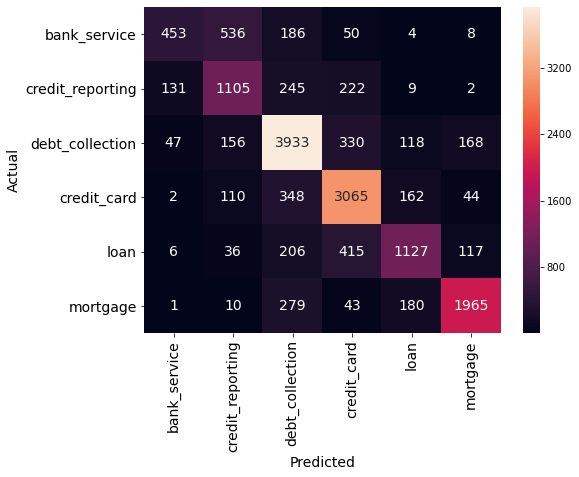

In [187]:
y_pred = mlpc.predict(text_bow_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 14}, fmt='d',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()

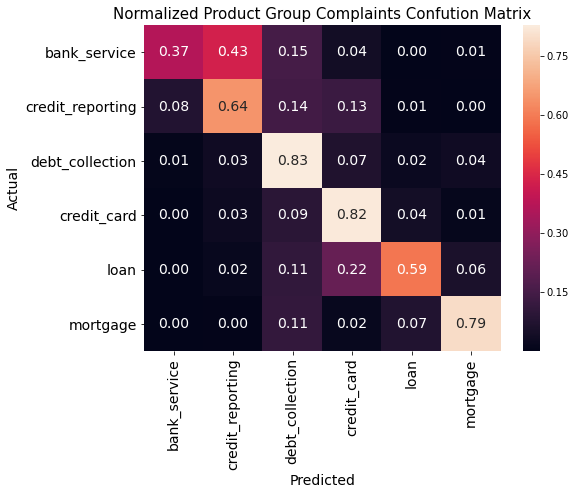

In [188]:
conf_sum = np.sum(conf_mat, axis=1, keepdims=True)
cm_perc = conf_mat / (conf_sum.astype(float))
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm_perc, annot=True, annot_kws={"size": 14}, fmt='.2f',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.title('Normalized Product Group Complaints Confution Matrix', fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()
%matplotlib inline

In [189]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

                  precision    recall  f1-score   support

    bank_service       0.71      0.37      0.48      1237
     credit_card       0.57      0.64      0.60      1714
credit_reporting       0.76      0.83      0.79      4752
 debt_collection       0.74      0.82      0.78      3731
            loan       0.70      0.59      0.64      1907
        mortgage       0.85      0.79      0.82      2478

        accuracy                           0.74     15819
       macro avg       0.72      0.67      0.69     15819
    weighted avg       0.74      0.74      0.73     15819



## Multi-class Support Vector Machine

In [190]:
from sklearn import svm
svm_class = svm.LinearSVC()
svm_class.fit(text_bow_train, y_train) 

C:\Users\jeff\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### SVM Scores
#### *Training Accuracy*

In [191]:
SVM_score = svm_class.score(text_bow_train, y_train)
SVM_score

0.9724531403103961

#### *Validation Accuracy*

In [192]:
SVM_val_score = svm_class.score(text_bow_test, y_test)
SVM_val_score

0.7963208799544851

The cross-validation score is very close to the model score, 94.32 versus 81.25. The naive Bayes model is a good fit of the data and will produce good predictions.


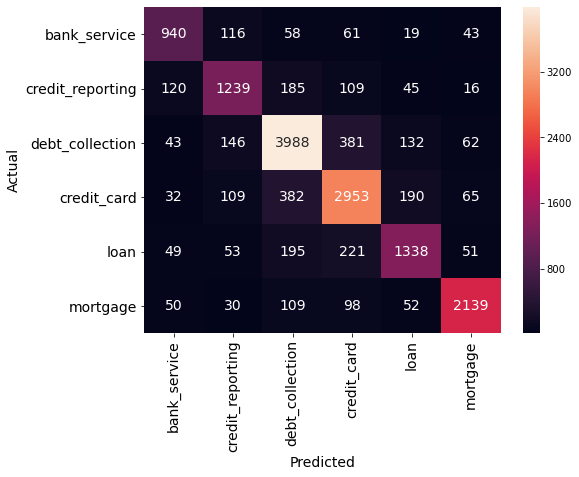

In [193]:
y_pred = svm_class.predict(text_bow_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 14}, fmt='d',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()

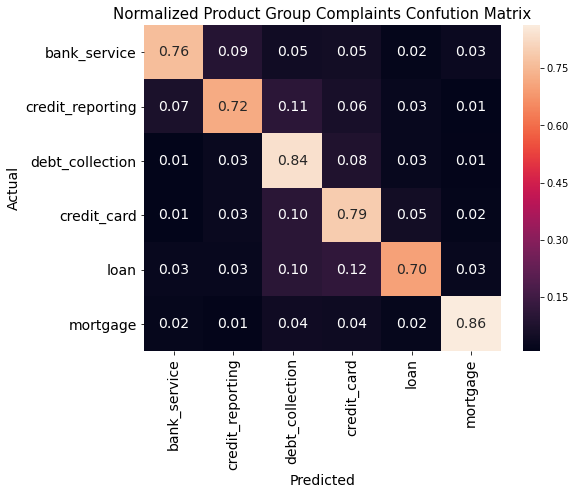

In [194]:
conf_sum = np.sum(conf_mat, axis=1, keepdims=True)
cm_perc = conf_mat / (conf_sum.astype(float))
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm_perc, annot=True, annot_kws={"size": 14}, fmt='.2f',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.title('Normalized Product Group Complaints Confution Matrix', fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
plt.show()
%matplotlib inline

In [195]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

                  precision    recall  f1-score   support

    bank_service       0.76      0.76      0.76      1237
     credit_card       0.73      0.72      0.73      1714
credit_reporting       0.81      0.84      0.82      4752
 debt_collection       0.77      0.79      0.78      3731
            loan       0.75      0.70      0.73      1907
        mortgage       0.90      0.86      0.88      2478

        accuracy                           0.80     15819
       macro avg       0.79      0.78      0.78     15819
    weighted avg       0.80      0.80      0.80     15819

